This notebook demonstrate how to use ifcopenshell to extract materials used in walls of a building model.

First we need to install required packages.

In [ ]:
%pip install ifcopenshell
%pip install lark numpy ## some package missing in the ifcopenshell
## install visualization package
%pip install matplotlib
%pip install seaborn

Import ifcopenshell and open the IFC file.

In [2]:
import os
import ifcopenshell
import pandas as pd

In [3]:
file_path = os.path.join(os.getcwd(), '..', 'examples', 'basic-house.ifc')
model = ifcopenshell.open(file_path)

Now we have the IFC model loaded. We are going to extract the materials used in the walls of the building. Including the common wall properties such as is external, is load bearing. We will also extract the quantity and dimensions of the wall materials.

In [4]:
# Extract walls
def extract_walls(ifc_file):
    """Extract wall elements from the IFC file."""
    return ifc_file.by_type('IfcWall')

extracted_walls = extract_walls(model)
print(f'Number of walls: {len(extracted_walls)}')


Number of walls: 13


In [5]:
extracted_walls = extract_walls(model)
print(f'Number of walls: {len(extracted_walls)}')
extracted_walls[0]

Number of walls: 13


#361=IfcWallStandardCase('2DedXznHnDaeAWsrTB_qBp',#41,'Basic Wall:Yttervägg Paroc:1298028',$,'Basic Wall:Yttervägg Paroc',#311,#359,'1298028')

### Extract Wall Materials

In [6]:
def format_material_name(material):
    """Format the material name to a readable format."""
    if material and material.is_a('IfcMaterial'):
        return material.Name
    return str(material)

def extract_material(wall):
    """Extract material information for a given wall, considering material layers if present."""
    material_info = []
    material_association = wall.HasAssociations
    if material_association:
        for assoc in material_association:
            if assoc.is_a('IfcRelAssociatesMaterial'):
                material = assoc.RelatingMaterial
                if material.is_a('IfcMaterialLayerSetUsage'):
                    for layer in material.ForLayerSet.MaterialLayers:
                        material_info.append({
                            'Material': format_material_name(layer.Material),
                            'LayerThickness': layer.LayerThickness
                        })
                elif material.is_a('IfcMaterialLayerSet'):
                    for layer in material.MaterialLayers:
                        material_info.append({
                            'Material': format_material_name(layer.Material),
                            'LayerThickness': layer.LayerThickness
                        })
                else:
                    material_info.append({
                        'Material': format_material_name(material),
                        'LayerThickness': None
                    })
                break
    return material_info

In [7]:
wall = extracted_walls[0]
material_info = extract_material(wall)
print(material_info)

[{'Material': 'Betong', 'LayerThickness': 540.0}]


### Extract Wall Properties

In [8]:
def extract_pset_wall_common(wall):
    """Extract PsetWallCommon properties for a given wall."""
    psets = ifcopenshell.util.element.get_psets(wall)
    pset_wall_common = psets.get('Pset_WallCommon', {})
    return pset_wall_common


In [9]:
wall_common_properties = extract_pset_wall_common(wall)
print(wall_common_properties)

{'Reference': 'Yttervägg Paroc', 'IsExternal': True, 'id': 530, 'ExtendToStructure': True, 'LoadBearing': False}


#### Extract Wall Quantity and Dimensions
We will use the BaseQuantities property set to extract the quantity and dimensions of the wall materials.

In [10]:
def extract_base_quantities(wall):
    """Extract base quantities for a given wall."""
    psets = ifcopenshell.util.element.get_psets(wall)
    pset_base_quantities = psets.get('BaseQuantities', {})
    return pset_base_quantities

In [11]:
wall_base_quantities = extract_base_quantities(wall)
print(wall_base_quantities)

{'Height': 2534.63712153532, 'Length': 22600.0, 'Width': 540.0, 'GrossFootprintArea': 12.204, 'NetVolume': 25.1098377156085, 'NetSideArea': 48.0210989466982, 'id': 378}


#### Find the units of the dimensions
To help us understand the dimensions, we will find the units of the dimensions.
We will need to find the assigned units in the IFC file.

In [12]:
def get_unit_string(unit):
    """Helper function to extract unit details."""
    if unit.is_a('IfcSIUnit'):
        return f"{unit.Prefix if unit.Prefix else ''}{unit.Name}"
    elif unit.is_a('IfcConversionBasedUnit'):
        primary_unit = unit.ConversionFactor.UnitComponent
        conversion_factor = unit.ConversionFactor.ValueComponent.wrappedValue
        return f"{unit.UnitType} ({unit.Name if unit.Name else ''}) defined as {primary_unit.UnitType} ({primary_unit.Prefix if primary_unit.Prefix else ''}{primary_unit.Name}) * {conversion_factor}"
    return None

def get_unit_of_project(model):
    """Get the units of the project, including length, area, and volume."""
    project = model.by_type('IfcProject')[0]
    units = {}

    # Extract units from project context
    project_units = project.UnitsInContext.Units
    length_units = [u for u in project_units if u.is_a() in ('IfcSIUnit', 'IfcConversionBasedUnit') and u.UnitType == 'LENGTHUNIT']
    area_units = [u for u in project_units if u.is_a() in ('IfcSIUnit', 'IfcConversionBasedUnit') and u.UnitType == 'AREAUNIT']
    volume_units = [u for u in project_units if u.is_a() in ('IfcSIUnit', 'IfcConversionBasedUnit') and u.UnitType == 'VOLUMEUNIT']

    # Get the last defined unit (if multiple are defined)
    if length_units:
        units['LENGTHUNIT'] = get_unit_string(length_units[-1])
    if area_units:
        units['AREAUNIT'] = get_unit_string(area_units[-1])
    if volume_units:
        units['VOLUMEUNIT'] = get_unit_string(volume_units[-1])

    # If no units are defined in project context, look at global context
    if not length_units or not area_units or not volume_units:
        global_unit_assignments = model.by_type('IfcUnitAssignment')
        global_length_units = [u for ua in global_unit_assignments for u in ua.Units if u.is_a() in ('IfcSIUnit', 'IfcConversionBasedUnit') and u.UnitType == 'LENGTHUNIT']
        global_area_units = [u for ua in global_unit_assignments for u in ua.Units if u.is_a() in ('IfcSIUnit', 'IfcConversionBasedUnit') and u.UnitType == 'AREAUNIT']
        global_volume_units = [u for ua in global_unit_assignments for u in ua.Units if u.is_a() in ('IfcSIUnit', 'IfcConversionBasedUnit') and u.UnitType == 'VOLUMEUNIT']

        if not length_units and global_length_units:
            units['LENGTHUNIT'] = get_unit_string(global_length_units[-1])
        if not area_units and global_area_units:
            units['AREAUNIT'] = get_unit_string(global_area_units[-1])
        if not volume_units and global_volume_units:
            units['VOLUMEUNIT'] = get_unit_string(global_volume_units[-1])

    return units

In [13]:
project_unit = get_unit_of_project(model)
print(project_unit)

{'LENGTHUNIT': 'MILLIMETRE', 'AREAUNIT': 'SQUARE_METRE', 'VOLUMEUNIT': 'CUBIC_METRE'}


In [14]:
# Function to append units to quantities
def append_units_to_quantities(base_quantities, units):
    """Append units to the base quantities."""
    length_unit = units.get('LENGTHUNIT', 'mm')
    area_unit = units.get('AREAUNIT', 'm2')
    volume_unit = units.get('VOLUMEUNIT', 'm3')

    if 'Height' in base_quantities:
        base_quantities['Height'] = f"{base_quantities['Height']} {length_unit}"
    if 'Length' in base_quantities:
        base_quantities['Length'] = f"{base_quantities['Length']} {length_unit}"
    if 'Width' in base_quantities:
        base_quantities['Width'] = f"{base_quantities['Width']} {length_unit}"
    if 'GrossFootprintArea' in base_quantities:
        base_quantities['GrossFootprintArea'] = f"{base_quantities['GrossFootprintArea']} {area_unit}"
    if 'NetVolume' in base_quantities:
        base_quantities['NetVolume'] = f"{base_quantities['NetVolume']} {volume_unit}"
    if 'NetSideArea' in base_quantities:
        base_quantities['NetSideArea'] = f"{base_quantities['NetSideArea']} {area_unit}"

    return base_quantities


In [15]:
# Extract base quantities for the wall
wall_base_quantities = extract_base_quantities(wall)
print("Base Quantities (Before appending units):")
print(wall_base_quantities)

# Get project units
units = get_unit_of_project(model)
print("\nProject Units:")
print(units)

# Append units to the base quantities
wall_base_quantities_with_units = append_units_to_quantities(wall_base_quantities, units)
print("\nBase Quantities (After appending units):")
print(wall_base_quantities_with_units)

Base Quantities (Before appending units):
{'Height': 2534.63712153532, 'Length': 22600.0, 'Width': 540.0, 'GrossFootprintArea': 12.204, 'NetVolume': 25.1098377156085, 'NetSideArea': 48.0210989466982, 'id': 378}

Project Units:
{'LENGTHUNIT': 'MILLIMETRE', 'AREAUNIT': 'SQUARE_METRE', 'VOLUMEUNIT': 'CUBIC_METRE'}

Base Quantities (After appending units):
{'Height': '2534.63712153532 MILLIMETRE', 'Length': '22600.0 MILLIMETRE', 'Width': '540.0 MILLIMETRE', 'GrossFootprintArea': '12.204 SQUARE_METRE', 'NetVolume': '25.1098377156085 CUBIC_METRE', 'NetSideArea': '48.0210989466982 SQUARE_METRE', 'id': 378}


### Extract building level of the wall
We will extract the building level of the wall to help us understand the location of the wall in the building.

In [16]:
def extract_element_level(element):
    """Extract the level (building storey) of a given element."""
    for rel in element.ContainedInStructure:
        if rel.is_a('IfcRelContainedInSpatialStructure'):
            relating_structure = rel.RelatingStructure
            if relating_structure.is_a('IfcBuildingStorey'):
                return relating_structure.Name
    return None

In [17]:
wall = extract_walls(model)[0]
level = extract_element_level(wall)
print(level)

Floor 0


### Create Material Passport for the walls

In [18]:
def create_material_passport(model):
    """Create a material passport for all wall elements in the IFC file."""
    walls = extract_walls(model)
    material_passport = []

    # Get project units
    units = get_unit_of_project(model)

    for wall in walls:
        wall_data = {'WallID': wall.GlobalId}

        # Extract PsetWallCommon properties and add to wall_data
        pset_wall_common = extract_pset_wall_common(wall)
        wall_data.update(pset_wall_common)

        # Extract base quantities and append units
        base_quantities = extract_base_quantities(wall)
        base_quantities_with_units = append_units_to_quantities(base_quantities, units)
        wall_data.update(base_quantities_with_units)

        # Extract level and add to wall_data
        level = extract_element_level(wall)
        wall_data['Level'] = level

        # Extract material and add to wall_data
        materials_info = extract_material(wall)
        for material_info in materials_info:
            material_passport.append({
                'WallID': wall.GlobalId,
                'Material': material_info['Material'],
                'LayerThickness': f"{material_info['LayerThickness']} {units.get('LENGTHUNIT', 'mm')}" if material_info['LayerThickness'] is not None else None,
                'Level': level,
                **pset_wall_common,
                **base_quantities_with_units
            })

    return pd.DataFrame(material_passport)

In [19]:
material_passport = create_material_passport(model)
material_passport.head()

,WallID,Material,LayerThickness,Level,Reference,IsExternal,id,ExtendToStructure,LoadBearing,Height,Length,Width,GrossFootprintArea,NetVolume,NetSideArea
0,2DedXznHnDaeAWsrTB_qBp,Betong,540.0 MILLIMETRE,Floor 0,Yttervägg Paroc,True,378,True,False,2534.63712153532 MILLIMETRE,22600.0 MILLIMETRE,540.0 MILLIMETRE,12.204 SQUARE_METRE,25.1098377156085 CUBIC_METRE,48.0210989466982 SQUARE_METRE
1,2DedXznHnDaeAWsrTB_qBo,Betong,540.0 MILLIMETRE,Floor 0,Yttervägg Paroc,True,645,True,False,3584.30801350511 MILLIMETRE,8960.0 MILLIMETRE,540.0 MILLIMETRE,4.83839999999999 SQUARE_METRE,12.0166799623208 CUBIC_METRE,22.2531110413347 SQUARE_METRE
2,2DedXznHnDaeAWsrTB_qBn,Betong,540.0 MILLIMETRE,Floor 0,Yttervägg Paroc,True,794,True,False,2534.63712153532 MILLIMETRE,22059.9999999999 MILLIMETRE,540.0 MILLIMETRE,11.9124 SQUARE_METRE,16.8538965977316 CUBIC_METRE,32.682894901069 SQUARE_METRE
3,2DedXznHnDaeAWsrTB_qBm,Betong,540.0 MILLIMETRE,Floor 0,Yttervägg Paroc,True,952,True,False,3584.30801350511 MILLIMETRE,8420.0 MILLIMETRE,540.0 MILLIMETRE,4.54680000000001 SQUARE_METRE,11.1674478700009 CUBIC_METRE,20.6804590185202 SQUARE_METRE
4,2DedXznHnDaeAWsrTB_qBj,Betong,170.0 MILLIMETRE,Floor 0,Innervägg 170mm Paroc,False,1072,False,False,2400.0 MILLIMETRE,8420.0 MILLIMETRE,170.0 MILLIMETRE,1.4314 SQUARE_METRE,2.782526 CUBIC_METRE,16.3678 SQUARE_METRE


#### Visualize the Material Passport

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
def visualize_walls_by_properties(material_passport, properties):
    """Visualize the count of walls by given properties in a 2x2 grid on a single canvas."""
    num_properties = len(properties)
    nrows = 2
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10))

    for ax, property_name in zip(axes.flat, properties):
        sns.countplot(data=material_passport, x=property_name, order=material_passport[property_name].value_counts().index, ax=ax)
        ax.set_title(f'Count of Walls by {property_name}')
        ax.set_xlabel(property_name)
        ax.set_ylabel('Count of Walls')
        for label in ax.get_xticklabels():
            label.set_rotation(45)
    
    # Hide any unused subplots
    for i in range(num_properties, nrows * ncols):
        fig.delaxes(axes.flat[i])
    
    plt.tight_layout()
    plt.show()


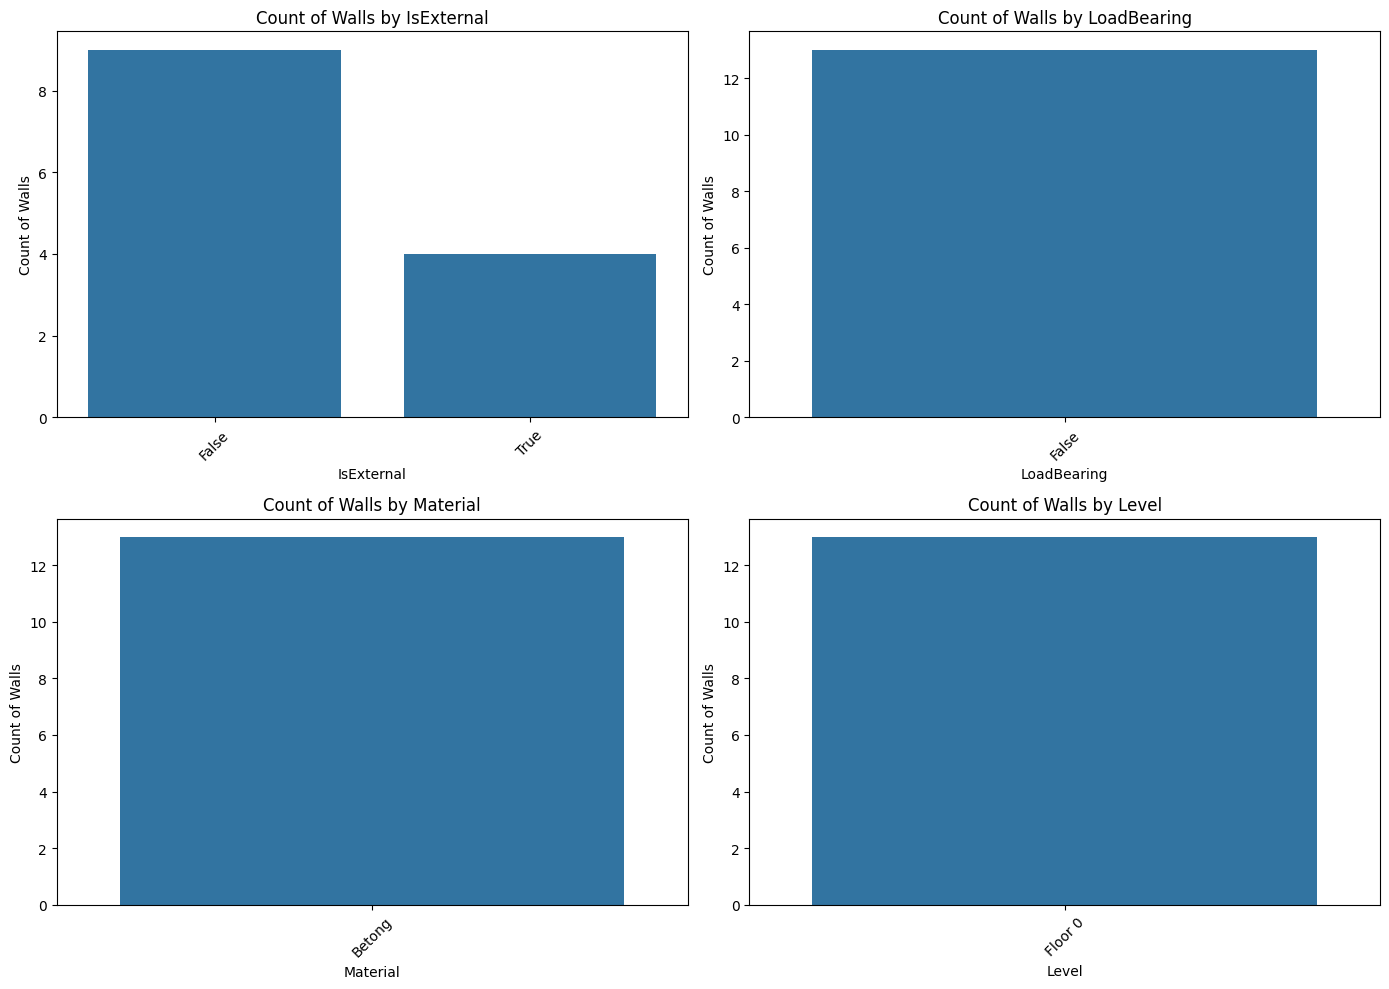

In [22]:
properties_to_visualize = ['IsExternal', 'LoadBearing', 'Material', 'Level']
visualize_walls_by_properties(material_passport, properties_to_visualize)


#### Export to CSV

In [23]:
## Save the material passport to a CSV file
material_passport.to_csv('material_passport_walls.csv', index=False)